In [1]:
import pandas as pd
from dbgsom.dbgsom_ import DBGSOM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, PowerTransformer, power_transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import seaborn.objects as so
from sklearn.impute import KNNImputer
from skimage.color import lab2rgb
import colour
import matplotlib as mpl


In [2]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
)


In [3]:
# Clean up data
data.replace(
    {
        -np.inf: -1000,
        np.inf: 1000,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
# convert timestamp to integer
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [4]:
scaler = PowerTransformer()
imputer = KNNImputer(add_indicator=True)
# One hot encode categorical columns
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[
        ("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_iter=500,
    random_state=32,
    convergence_iter=10,
    spreading_factor=1.5,
    verbose=True,
    max_neurons=500,
    growth_criterion="entropy",
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
        ("som", som),
    ]
)

pipe_small = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [5]:
pipe.fit(X_train, y_train)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 65%|██████▌   | 325/500 [02:41<01:27,  2.01 epochs/s]


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=10),
                                                  ['Src IP', 'Src Port',
                                                   'Dst IP', 'Dst Port',
                                                   'Protocol'])],
                                   verbose_feature_names_out=False)),
                ('scaler', PowerTransformer()),
                ('imputer', KNNImputer(add_indicator=True)),
                ('som',
                 DBGSOM(convergence_iter=10, growth_criterion='entropy',
                        max_iter=500, max_neurons=500, random_state=32,
                        spreading_factor=1.5, verbose=True))])

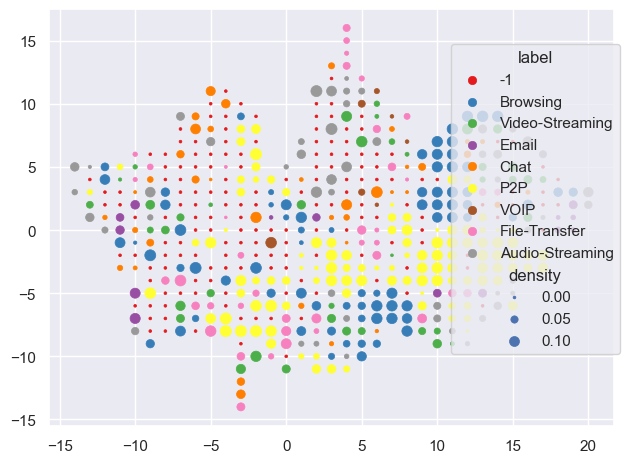

In [38]:
som.plot(
    # color="density",
    color="label",
    palette="Set1",
    pointsize="density",
)


In [7]:
weights = som.weights_

weights_split = pd.DataFrame((pd.Series(feature) for feature in weights))
# Add feature names as columns
names = col_transformer.get_feature_names_out().tolist()
names.append("x")

weights_split.columns = names


In [44]:
# L*a*b* is better suited to display distances
# between colors. Thats why we convert to rgb only later.
# Reference: Cluster coloring of the Self-Organizing Map: An information visualization perspective
# Peter Sarlin and Samuel Rönnqvist

pca = PCA(n_components=3)
pca_components = pca.fit_transform(weights_split)

pca_components_scaled = (pca_components - pca_components.min()) / (
    pca_components - pca_components.min()
).max()


In [55]:
colors_lab = np.copy(pca_components)

# # Full color scale
# colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (0, 100))
# colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-128, 127))
# colors_lab[:, 2] = minmax_scale(colors_lab[:, 2], (-128, 127))

# Red-blue spectrum
colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (10, 90))
colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-100, 100))
colors_lab[:, 2] = colors_lab[:, 1]

# Red-green spectrum
# colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (10, 90))
# colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-60, 60))
# colors_lab[:,2] = 40

colors_rgb = lab2rgb(colors_lab)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 37 pixels
  return func(*args, **kwargs)


In [56]:
# colors_cam16 = np.copy(pca_components_scaled)
# colors_cam16[:,0] = minmax_scale(colors_cam16[:,0], (0.1, 0.9))
# colors_cam16[:,1] = minmax_scale(colors_cam16[:,1], (-0.4, 0.4))
# colors_cam16[:,2] = minmax_scale(colors_cam16[:,2], (-0.4, 0.4))
# colors_rgb2 = colour.convert(colors_cam16, "CAM16UCS", "sRGB")


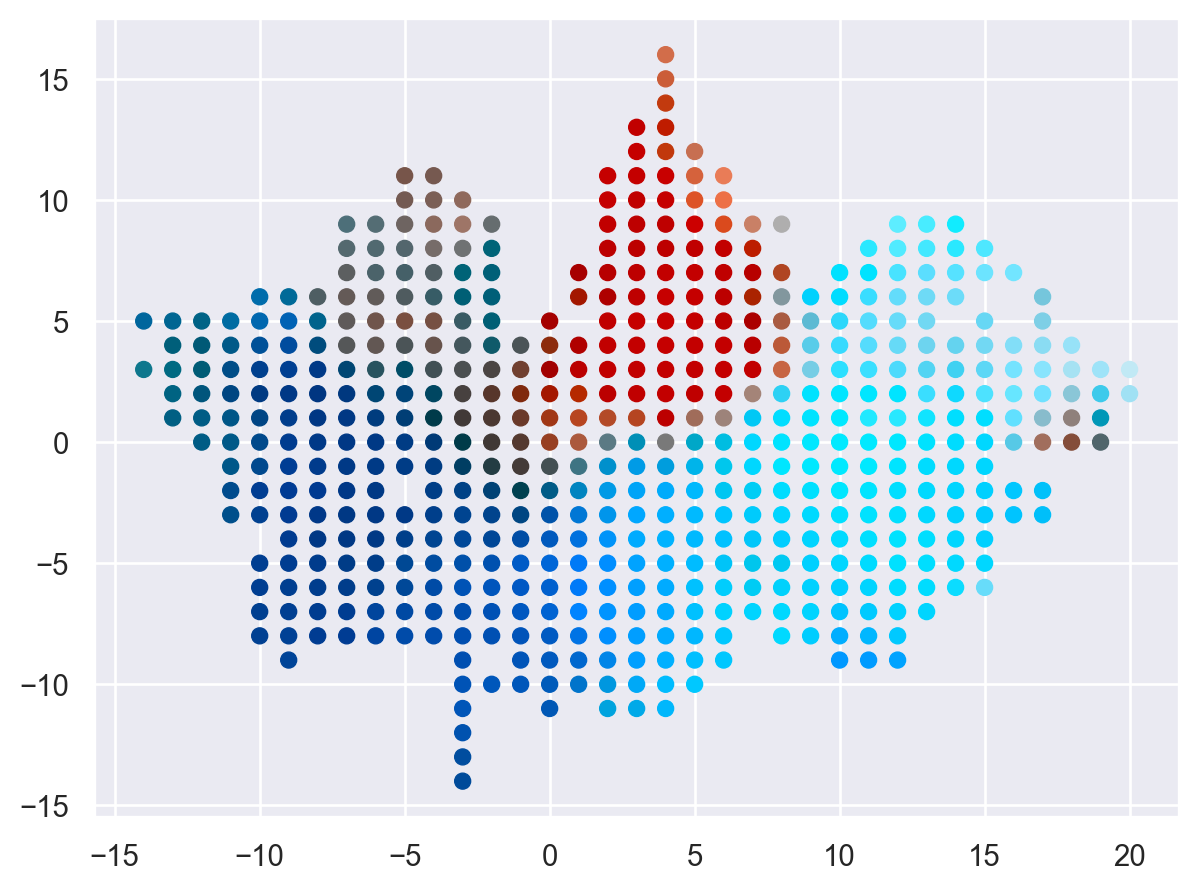

In [57]:
hex_colors = [mpl.colors.rgb2hex(c) for c in colors_rgb]

p = (
    so.Plot(
        x=np.array(som.som_.nodes)[:, 0],
        y=np.array(som.som_.nodes)[:, 1],
        color=hex_colors,
    )
    .add(so.Dot())
    .scale(color=None)
)
p.save("darknet_pca.png")


In [58]:
print(f"Topographic error: {som.topographic_error_}")

print(f"Accuracy: {pipe.score(X_test, y_2_test)}")

print(
    f"""F1 score: {f1_score(
    y_2_test,
    pipe.predict(X_test),
    average="macro"
    )
}"""
)

print(f"Growing Threshold: {som.growing_threshold_}")


Topographic error: 0.06106625717165817
Accuracy: 0.8195461097137043
F1 score: 0.5904789285533544
Growing Threshold: 1.5


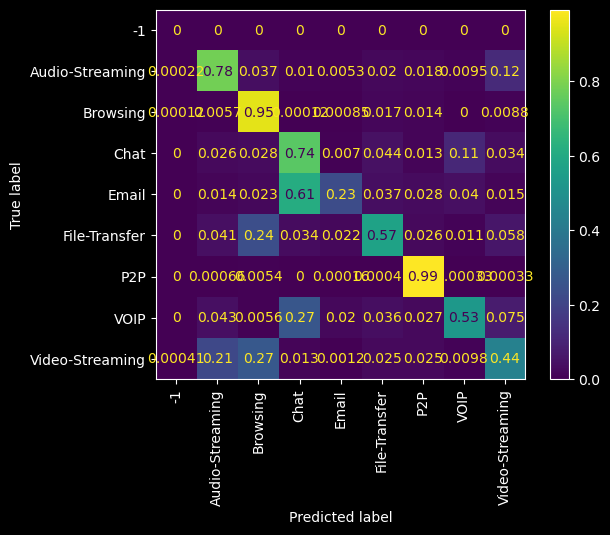

In [59]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_2_test,
    pipe.predict(X_test),
    normalize="true",
    xticks_rotation="vertical",
    # values_format="f{.3}"
)
